In [1]:
import devito as dv
import sympy as sp

In [2]:
grid = dv.Grid(shape=(201, 201), extent=(1000., 1000.))
p = dv.TimeFunction(name='p', grid=grid, space_order=16)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=16, staggered=(None, None))
vx, vy = v

# Material parameters
c = dv.Function(name='c', grid=grid, space_order=4)
rho = dv.Function(name='rho', grid=grid, space_order=4)
c.data[:] = 1.
rho.data_with_halo[:] = 1. # Encountering zeros in the halo here is bad

# Define bouyancy for shorthand
b = 1/rho
# Define square celerity for shorthand
c2 = c**2  # FIXME: This prints missing the ^2 (string does contain **2 however)

In [3]:
dt = grid.stepping_dim.spacing

In [4]:
# For setting up the 2nd-order ADER scheme

# First time derivatives
pdt = rho*c2*dv.div(v)
vdt = b*dv.grad(p)

# Second time derivatives
pdt2 = c2*p.laplace

# dv.grad(dv.div(v)) does not get flattened and will need to be explicitly written out
def graddiv(f):
    return sp.Matrix([[f[0].dx2 + f[1].dxdy],
                      [f[0].dxdy + f[1].dy2]])


vdt2 = c2*graddiv(v)

# Variable material parameter assumption not made
# pdt2 = rho*c2*(dv.grad(b).dot(dv.grad(p)) + b*p.laplace)
# vdt2 = b*(dv.grad(rho)*c2*dv.div(v) + rho*dv.grad(c2)*dv.div(v) + rho*c2*graddiv(v))

In [5]:
# For a 3rd-order ADER scheme
c4 = c**4

def lapdiv(f):
    return f[0].dx3 + f[0].dxdy2 + f[1].dx2dy + f[1].dy3

def gradlap(f):
    return sp.Matrix([[f.dx3 + f.dxdy2],
                      [f.dx2dy + f.dy3]])

pdt3 = rho*c4*lapdiv(v)

vdt3 = c2*b*gradlap(p)

In [6]:
# For a 4th-order ADER scheme

def gradlapdiv(f):
    return sp.Matrix([[f[0].dx4 + f[0].dx2dy2 + f[1].dx3dy + f[1].dxdy3],
                      [f[0].dx3dy + f[0].dxdy3 + f[1].dx2dy2 + f[1].dy4]])\

def biharmonic(f):
    return f.dx4 + 2*f.dx2dy2 + f.dy4

pdt4 = c4*biharmonic(p)

vdt4 = c4*gradlapdiv(v)

In [7]:
# Model timestep
op_dt = 0.8*grid.spacing[0]
# TODO: Need to figure out the stability limit for this method

In [8]:
# Update equations (2nd-order ADER timestepping)
# eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2)
# eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2)

# Update equations (3rd-order ADER timestepping)
# eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2 + (dt**3/6)*pdt3)
# eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2 + (dt**3/6)*vdt3)

# Update equations (4th-order ADER timestepping)
eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2 + (dt**3/6)*pdt3 + (dt**4/24)*pdt4)
eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2 + (dt**3/6)*vdt3 + (dt**4/24)*vdt4)

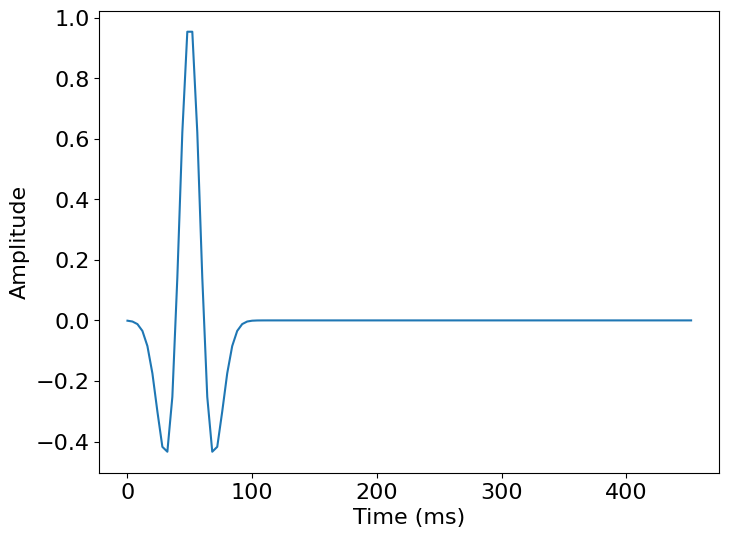

In [9]:
import numpy as np
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts a t=0
tn = 450.  # Simulation last 1 second (1000 ms)

time_range = TimeAxis(start=t0, stop=tn, step=op_dt)

f0 = 0.020  # Source peak frequency is 20Hz (0.020 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = np.array(grid.extent) * .5

# We can plot the time signature to see the wavelet
src.show()

Operator `Kernel` ran in 0.04 s


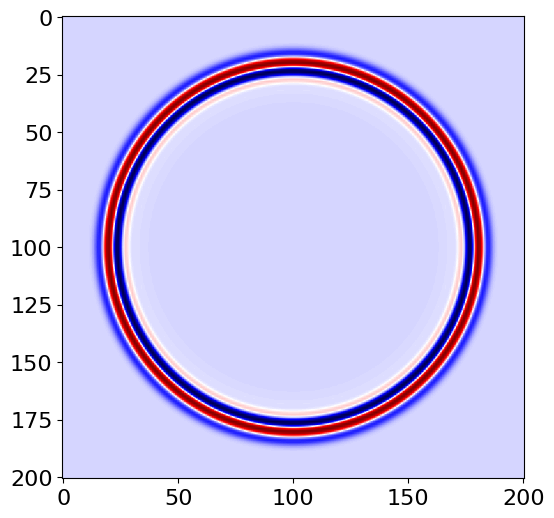

In [10]:
import matplotlib.pyplot as plt

src_term = src.inject(field=p.forward, expr=src)

op = dv.Operator([eq_p, eq_v] + src_term)
op.apply(dt=op_dt)

plt.imshow(p.data[-1], cmap='seismic')
plt.show()